### Notebook for the CCI-derived metabolism from scRNA-Seq using `mebocost` - Cardiomyocytes

- **Developed by**: Carlos Talavera-López Ph.D
- **Institute of Computational Biology - Computational Health Centre - Hemlholtz Munich**
- v240312

### Import required modules

In [1]:
import os,sys
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from mebocost import mebocost

Warning (xlmhg): Failed to import "mhg_cython" C extension.
Warning (xlmhg): Failed to import the "mhg_cython" C extension.Falling back to the pure Python implementation, which is very slow.


In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
PIL                         10.2.0
adjustText                  NA
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        23.2.0
attrs                       23.2.0
babel                       2.14.0
beta_ufunc                  NA
binom_ufunc                 NA
certifi                     2023.11.17
cffi                        1.16.0
charset_normalizer          3.3.2
comm                        0.2.1
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.8.0
decorator                   5.1.1
defusedxml                  0.7.1
exceptiongroup              1.2.0
executing                   2.0.1
fastjsonschema              NA
fontTools                   4.47.0
fqdn                        NA
h5py                        3.10.0
hypergeom_ufunc             NA
idna                        3.6
ipykernel

### Read in dataset

In [3]:
mixed = sc.read_h5ad('../../data/Kdm6aKO_ALL_GEX_CMC_states_ctl240311.raw.h5ad') 
mixed

AnnData object with n_obs × n_vars = 10793 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'group', 'file', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'genome', 'modality', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

In [4]:
mixed.obs['genotype'].cat.categories

Index(['KO', 'Sham', 'Tx', 'WT'], dtype='object')

In [5]:
mixed.obs['C_scANVI'].cat.categories

Index(['vCM1', 'vCM2', 'vCM3', 'vCM4'], dtype='object')

In [6]:
adata = mixed[mixed.obs['genotype'].isin(['Tx'])]
adata

View of AnnData object with n_obs × n_vars = 2348 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'group', 'file', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'genome', 'modality', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

- Is data raw?

In [7]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis = 0))

In [8]:
X_is_raw(adata)

True

### Infer Highly Variable Genes to speed up and improve inference

In [9]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "sample",
    subset = True,
    span = 1
)

adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 2348 × 7000
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'group', 'file', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'genome', 'modality', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts'

### Infer metabolic communications

- The `mebocost.conf` file needs to be provided. It is in the original repo and after installation it will have the correct paths and should work out of the box. You could provide the full path to the file, or create a symlink. 

In [10]:
mebo_obj = mebocost.create_obj(
                        adata = adata,
                        group_col = ['C_scANVI'],
                        met_est = 'mebocost',
                        config_path = './mebocost.conf',
                        exp_mat = None,
                        cell_ann = None,
                        species = 'mouse',
                        met_pred = None,
                        met_enzyme = None,
                        met_sensor = None,
                        met_ann = None,
                        scFEA_ann = None,
                        compass_met_ann = None,
                        compass_rxn_ann = None,
                        gene_network = None,
                        gmt_path = None,
                        cutoff_exp = 'auto', ## automated cutoff to exclude lowly ranked 25% sensors across all cells
                        cutoff_met = 'auto', ## automated cutoff to exclude lowly ranked 25% metabolites across all cells
                        cutoff_prop = 0.10, ## at lease 25% of cells should be expressed the sensor or present the metabolite in the cell group (specified by group_col)
                        sensor_type = ['Receptor', 'Transporter', 'Nuclear Receptor'],
                        thread = 16
                        )

[March 12, 2024 09:53:00]: We get expression data with 7000 genes and 2348 cells.
[March 12, 2024 09:53:00]: Data Preparation Done in 0.0082 seconds


### Estimate metabolite presence

- If you just want the table of metabolic activity, you can stop here and export it as a CSV file. 

In [11]:
mebo_obj._load_config_()
mebo_obj.estimator()

[March 12, 2024 09:53:00]: Load config and read data based on given species [mouse].
[March 12, 2024 09:53:01]: Estimtate metabolite level using mebocost


In [12]:
met_mat = pd.DataFrame(mebo_obj.met_mat.toarray(),
                      index = mebo_obj.met_mat_indexer,
                      columns = mebo_obj.met_mat_columns)
met_mat.head()

,AAACAGCCAGATAGAC-1-GSKJ4_treat_47,AAACCAACACCCACCT-1-GSKJ4_treat_47,AAACCGCGTGGGTGAA-1-GSKJ4_treat_47,AAACGGATCCAGGTCA-1-GSKJ4_treat_47,AAAGCAAGTTAAGCTG-1-GSKJ4_treat_47,AAAGCCCGTTGGATAT-1-GSKJ4_treat_47,AAAGCCGCATCAGCAC-1-GSKJ4_treat_47,AAAGCTTGTGTTGCTT-1-GSKJ4_treat_47,AAAGGACGTTATGTGG-1-GSKJ4_treat_47,AAAGGCTCACCTATAG-1-GSKJ4_treat_47,...,TTTGAGTCATAAGCAA-1-GSKJ4_treat_52,TTTGAGTCATGCAACC-1-GSKJ4_treat_52,TTTGAGTCATGCTCCC-1-GSKJ4_treat_52,TTTGCATTCGGTTTCC-1-GSKJ4_treat_52,TTTGGCTGTAAGCACC-1-GSKJ4_treat_52,TTTGGCTGTTCACCAT-1-GSKJ4_treat_52,TTTGGTAAGGGATTAG-1-GSKJ4_treat_52,TTTGTCTAGTACTGGT-1-GSKJ4_treat_52,TTTGTCTAGTCATGCG-1-GSKJ4_treat_52,TTTGTTGGTCCTAACT-1-GSKJ4_treat_52
HMDB0003450,0.0,0.000000,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00
HMDB0003948,0.0,0.666667,1.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,1.333333,0.666667,0.0,0.666667,0.0,0.333333,0.0,0.666667,0.0,0.00
HMDB0003712,0.0,0.666667,1.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,1.333333,0.666667,0.0,0.666667,0.0,0.333333,0.0,0.666667,0.0,0.00
HMDB0003945,0.0,0.500000,0.75,0.0,0.0,0.25,0.0,0.0,0.0,0.0,...,1.000000,0.750000,0.0,0.500000,0.0,0.250000,0.0,0.500000,0.0,0.25
HMDB0003949,0.0,0.666667,1.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,1.333333,0.666667,0.0,0.666667,0.0,0.333333,0.0,0.666667,0.0,0.00


In [13]:
met_mat.shape

(370, 2348)

### MEBOCOST cell-cell communication inference

In [14]:
commu_res = mebo_obj.infer_commu(
                                n_shuffle = 1000,
                                seed = 1712, 
                                Return = True, 
                                thread = 16,
                                save_permuation = False,
                                min_cell_number = 3
                            )

[March 12, 2024 09:53:06]: Load config and read data based on given species [mouse].
[March 12, 2024 09:53:07]: Estimtate metabolite level using mebocost
[March 12, 2024 09:53:13]: Infer communications
[March 12, 2024 09:53:13]: Sensor type used ['Transporter', 'Receptor', 'Nuclear Receptor']
[March 12, 2024 09:53:13]: Parameters: {shuffling: 1000 times, random seed: 1712, thread: 16}
[March 12, 2024 09:53:13]: met_sensor: (78, 8)
[March 12, 2024 09:53:13]: avg_exp: (732, 4) for (gene, cell) of needed
[March 12, 2024 09:53:13]: avg_met: (370, 4) for (metabolite, cell) of needed
[March 12, 2024 09:53:13]: shuffling 1000 times for generating backgroud
[March 12, 2024 09:53:13]: take exp and met avg for shuffling
[March 12, 2024 09:53:17]: thread: 16
[March 12, 2024 09:53:17]: Slc7a1 ~ HMDB0000517
[March 12, 2024 09:53:17]: Cd36 ~ HMDB0000067
[March 12, 2024 09:53:17]: Normalizing Cluster Mean and Calculating Communication Score
[March 12, 2024 09:53:17]: Calculating P-value
[March 12, 20

In [15]:
print('sensor_exp cutoff: %s'%mebo_obj.cutoff_exp)
print('metabolite_presence cutoff: %s'%mebo_obj.cutoff_met)

sensor_exp cutoff: 1.0
metabolite_presence cutoff: 0.25


### Visualise MEBOCOST prediction

- Summary of the number of communication events

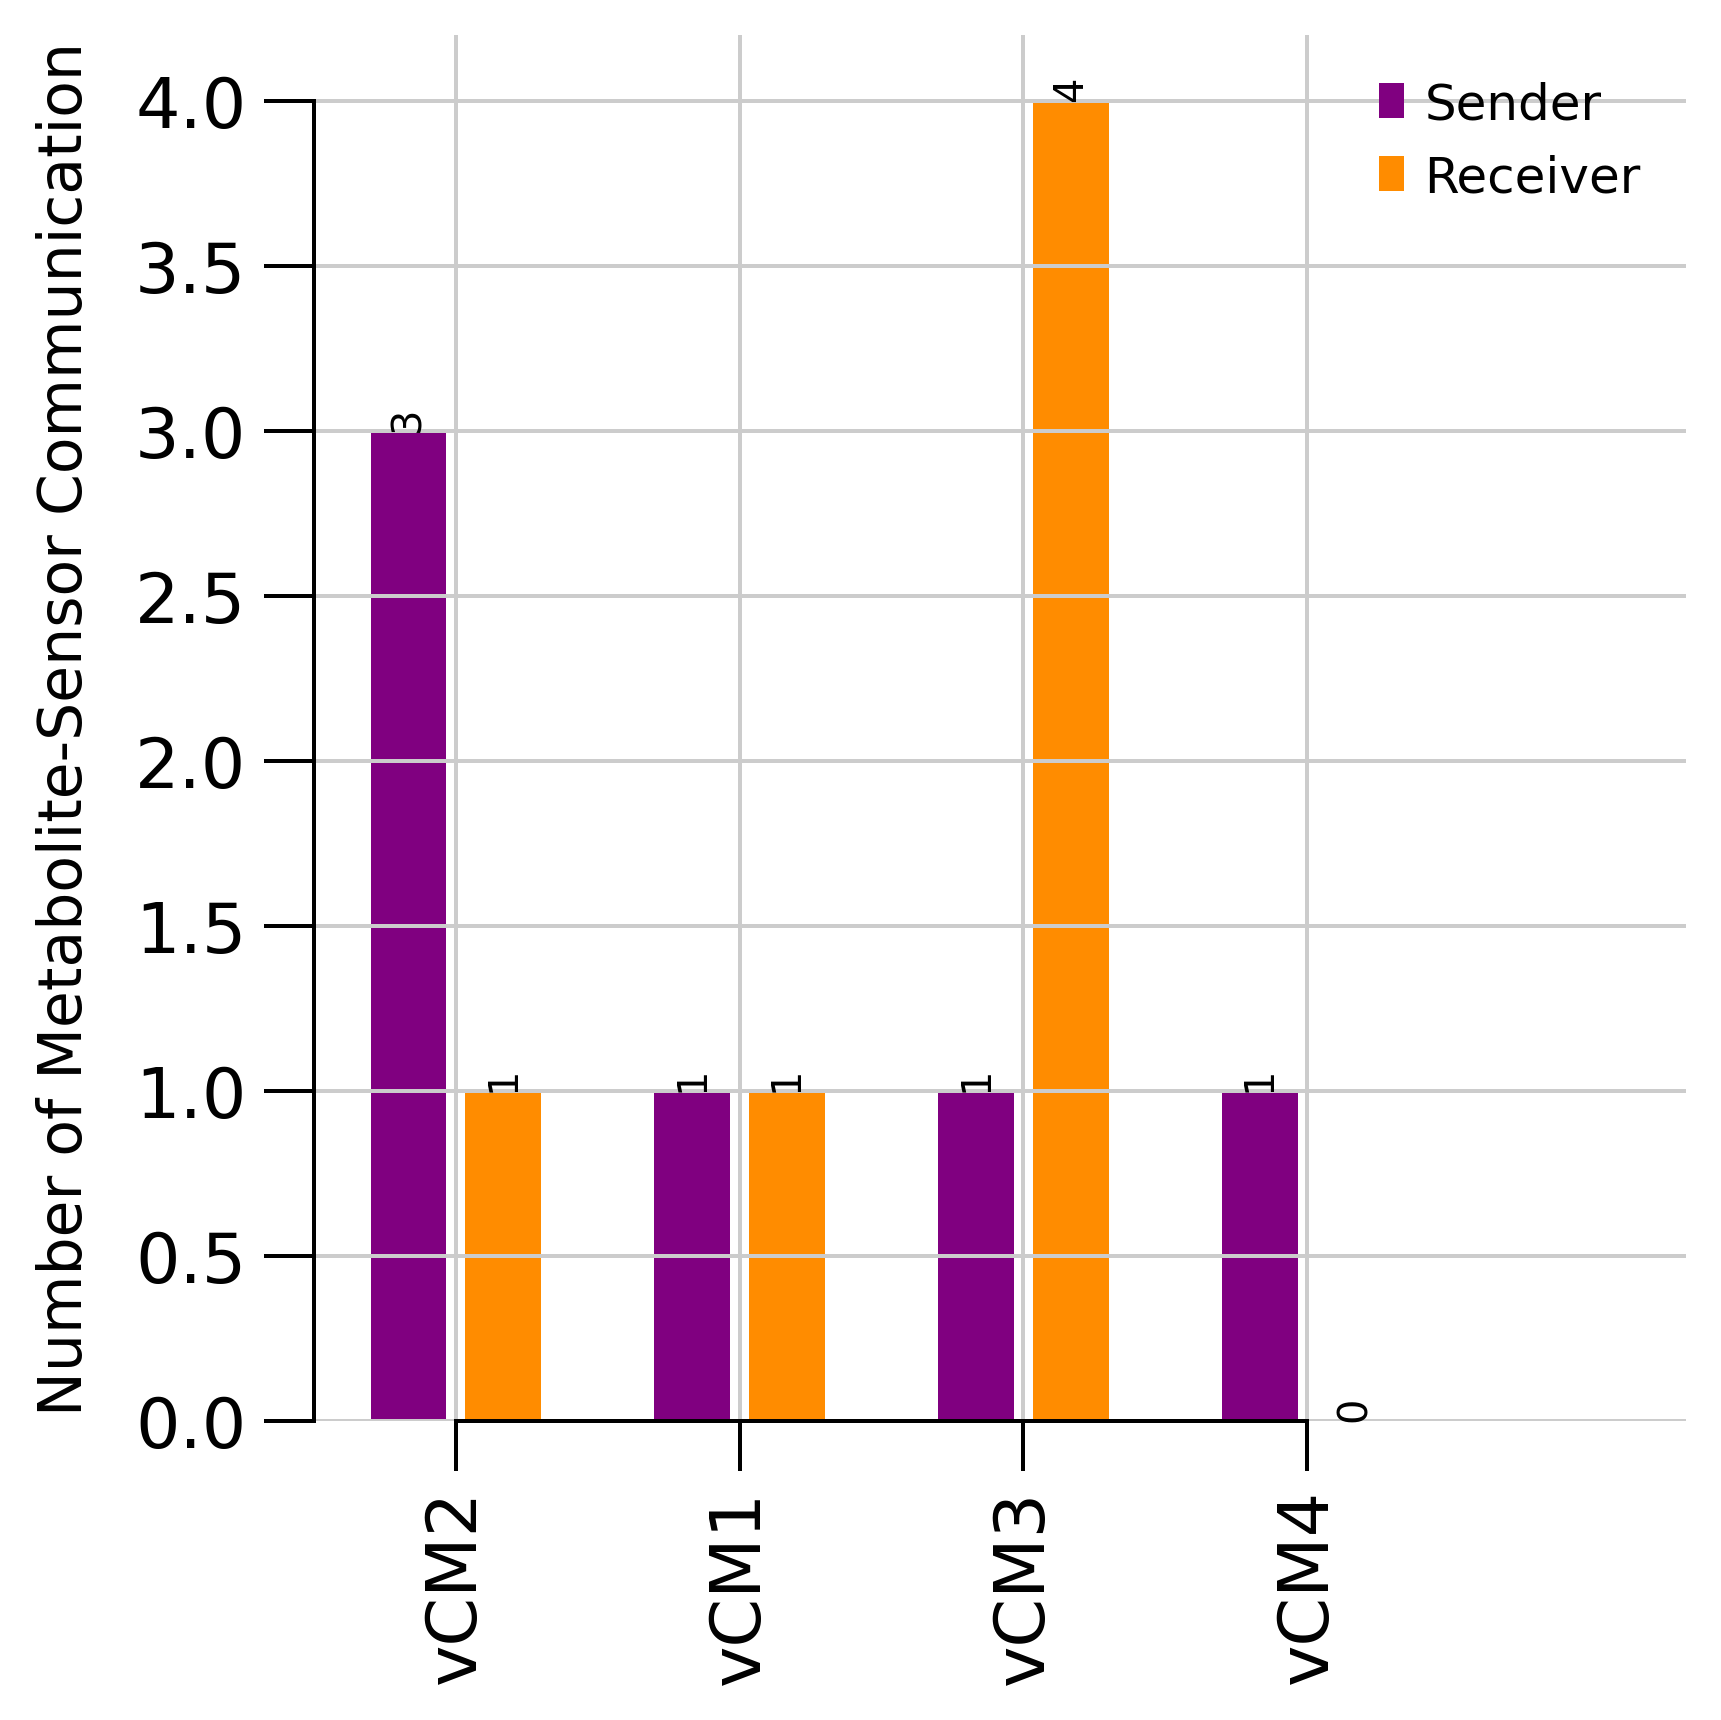

In [16]:
mebo_obj.eventnum_bar(
                    sender_focus = [],
                    metabolite_focus = [],
                    sensor_focus = [],
                    receiver_focus = [],
                    and_or = 'and',
                    pval_method = 'permutation_test_fdr',
                    pval_cutoff = 0.05,
                    comm_score_col = 'Commu_Score',
                    comm_score_cutoff = 0,
                    cutoff_prop = 0.25,
                    figsize = (5,5),
                    save = None,
                    show_plot = True,
                    show_num = True,
                    include = ['sender-receiver'],
                    group_by_cell = True,
                    colorcmap = 'Dark2',
                    return_fig = False
                )

- Showing the communication between sender and receiver in a dot plot

[March 12, 2024 09:53:25]: plot dot plot to show communication in cell type level


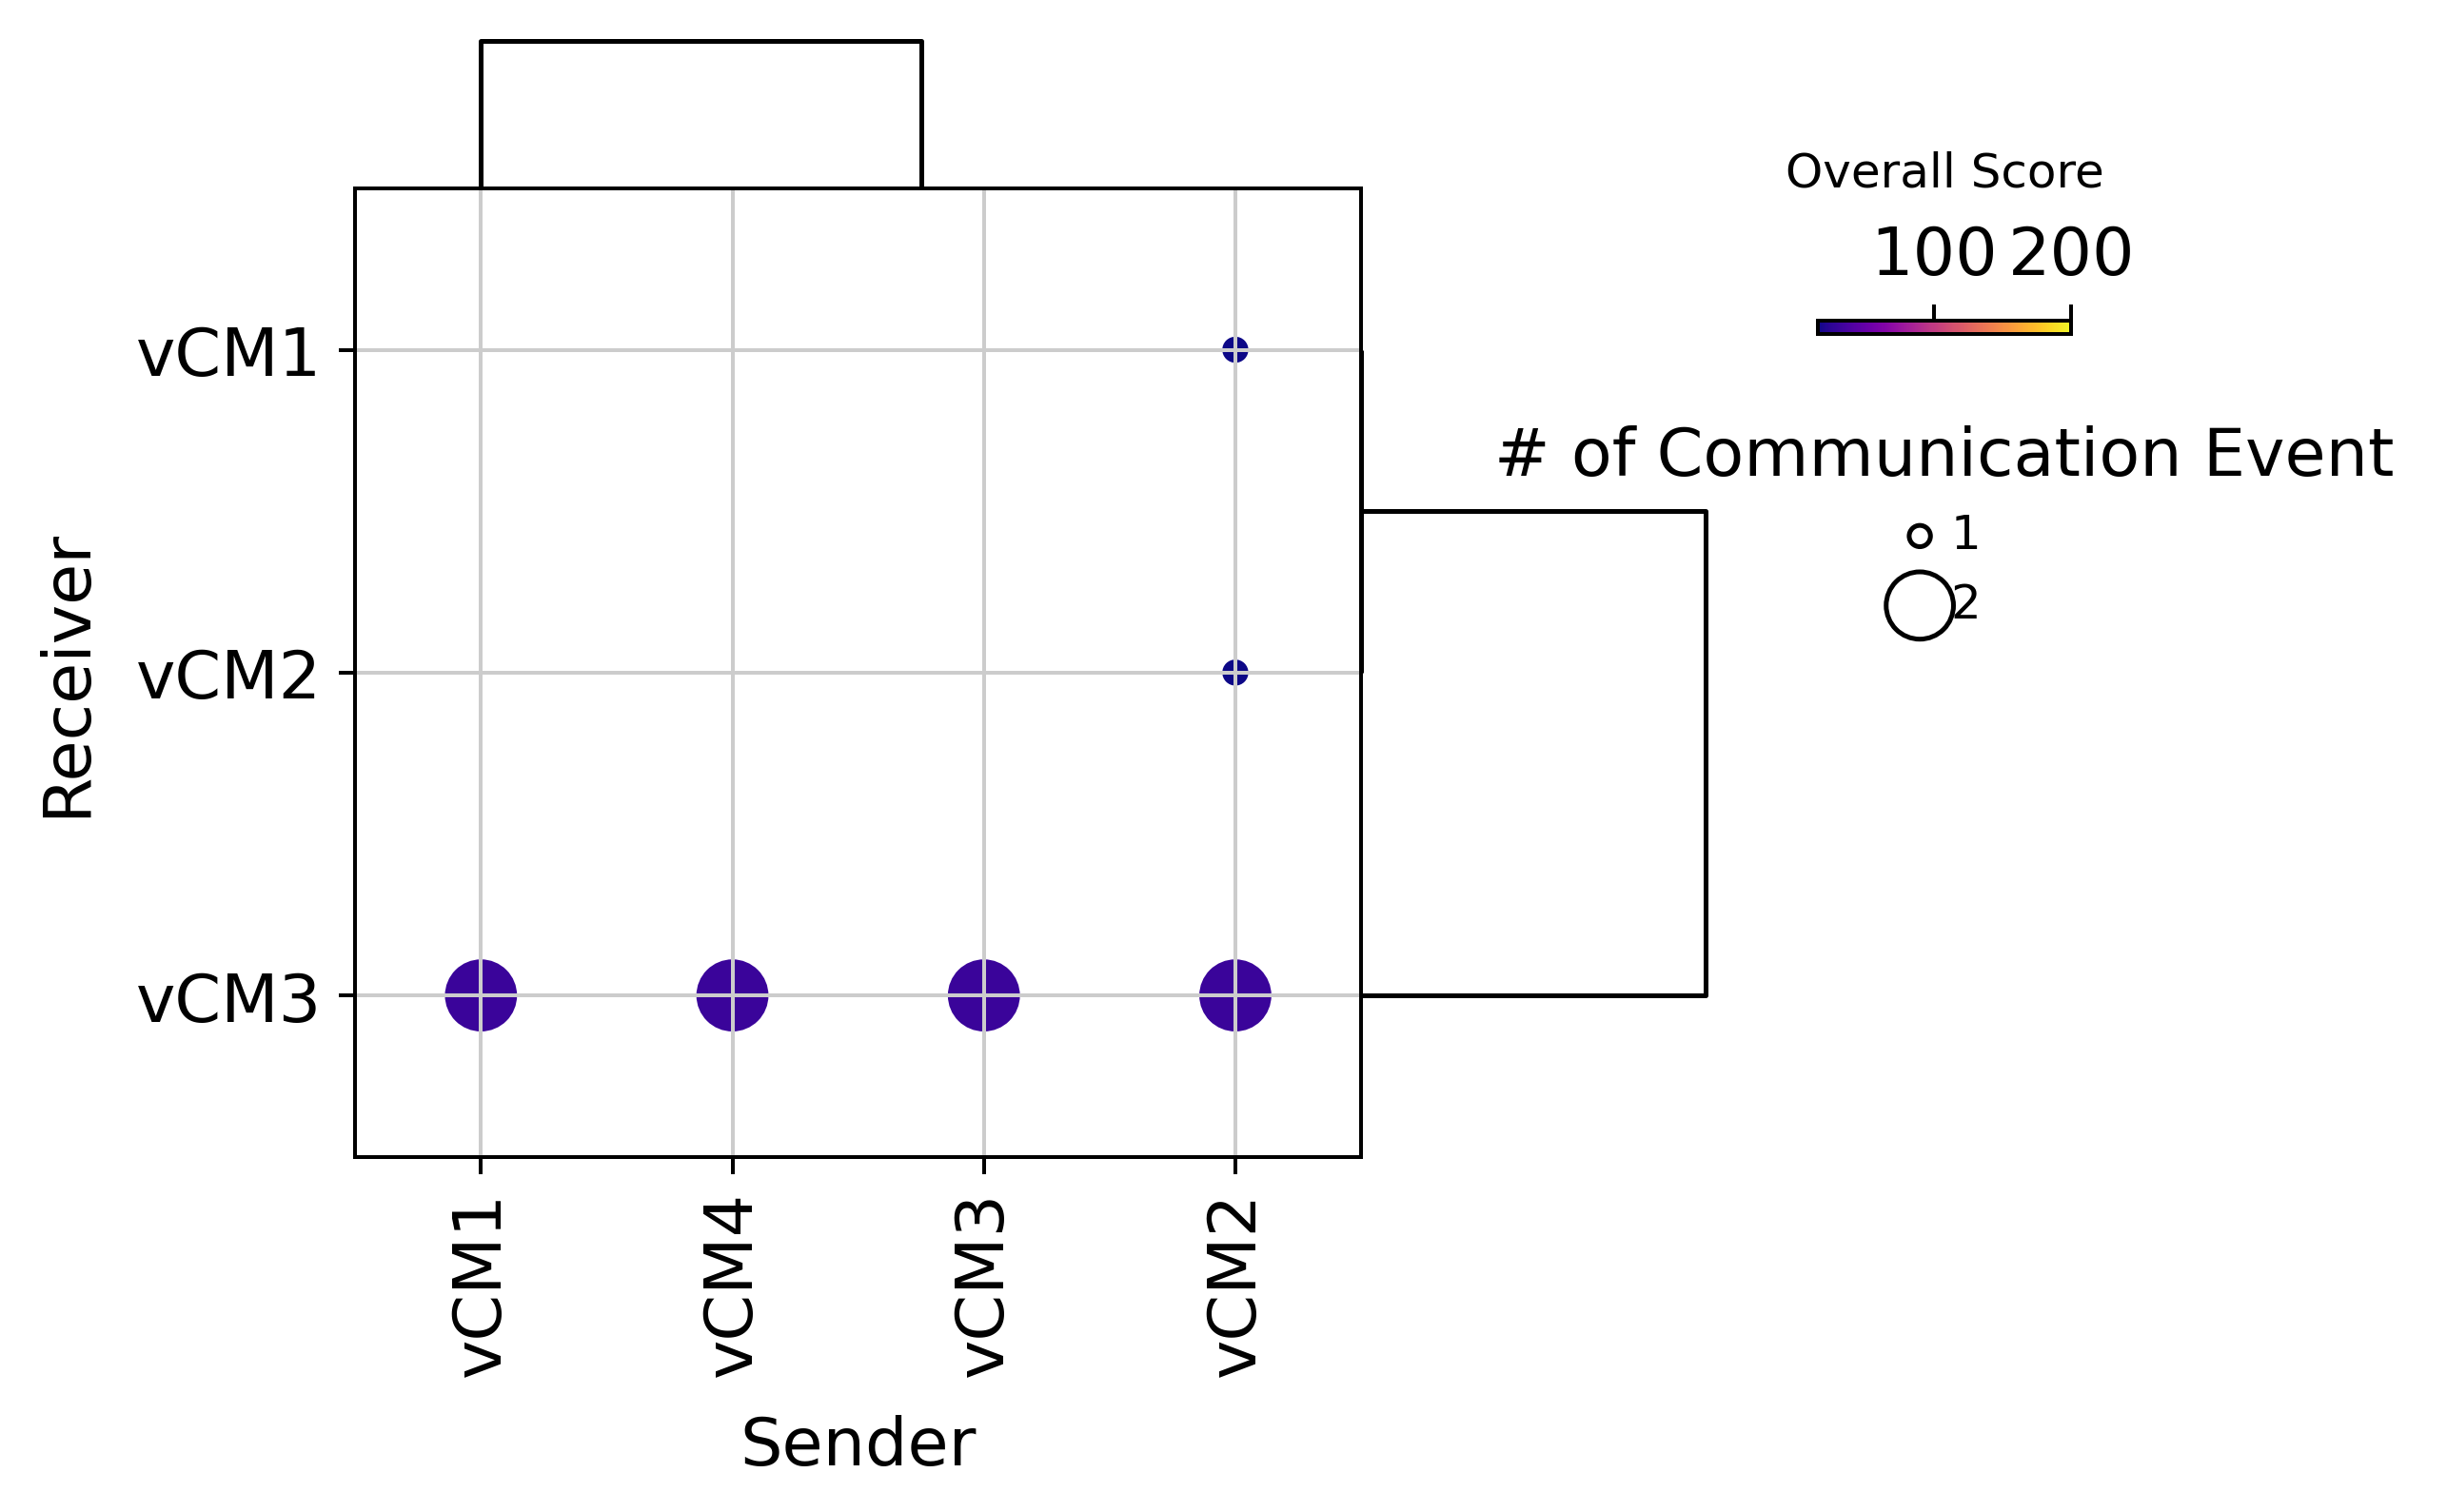

In [17]:
mebo_obj.count_dot_plot(
                        pval_method = 'permutation_test_fdr',
                        pval_cutoff = 0.05,
                        cmap = 'plasma',
                        figsize = 'auto',
                        save = None,
                        dot_size_norm = (20, 200),
                        dot_color_vmin = None,
                        dot_color_vmax = 200,
                        show_plot = True,
                        comm_score_col = 'Commu_Score',
                        comm_score_cutoff = 0,
                        return_fig = False
                    )

- Showing the detailed communications (sender-receiver vs metabolite-sensor) in a dot map

[March 12, 2024 09:53:25]: plot heatmap for significant result


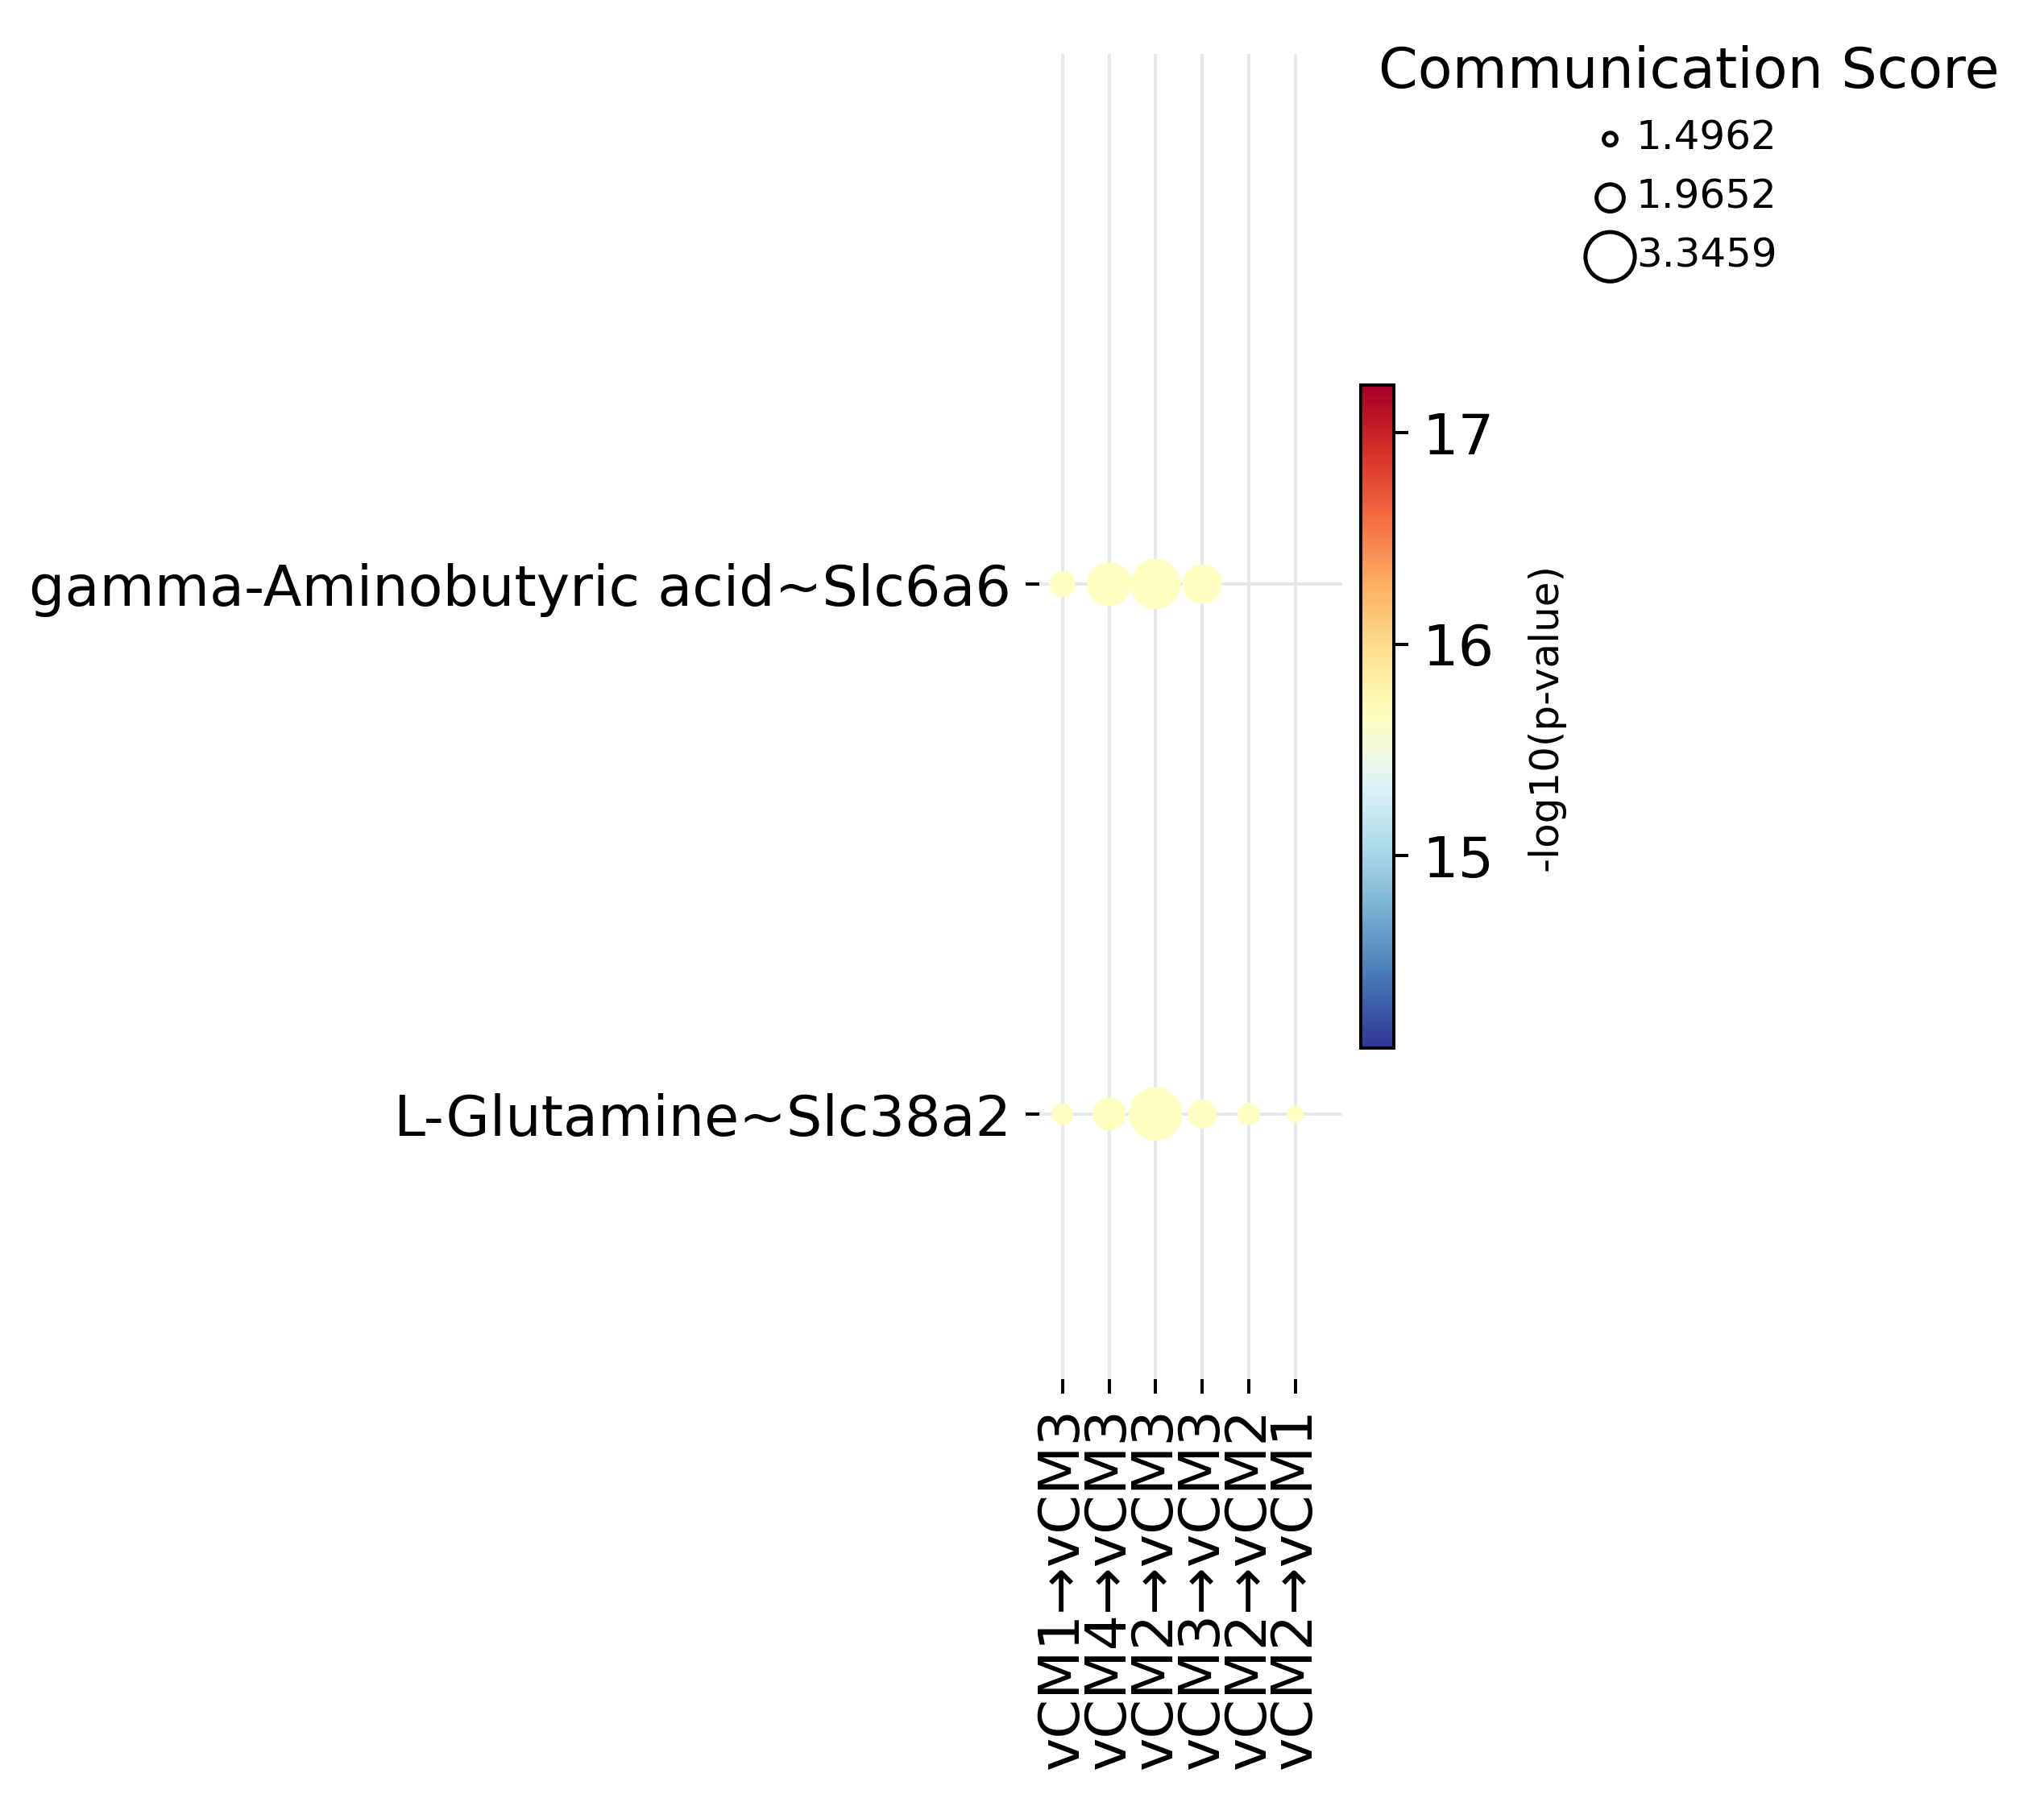

In [18]:
mebo_obj.commu_dotmap(
                sender_focus = [],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = [],
                and_or = 'and',
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                figsize = 'auto',
                cmap = 'RdYlBu_r',
                node_size_norm = (10, 150),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                swap_axis = False,
                return_fig = False
                )

- Visualization of the communication flow from sender metabolite to sensor in receiver

[March 12, 2024 09:53:26]: plot flow plot to show the communications from Sender -> Metabolite -> Sensor -> Receiver


RuntimeError: Colorbar layout of new layout engine not compatible with old engine, and a colorbar has been created.  Engine not changed.

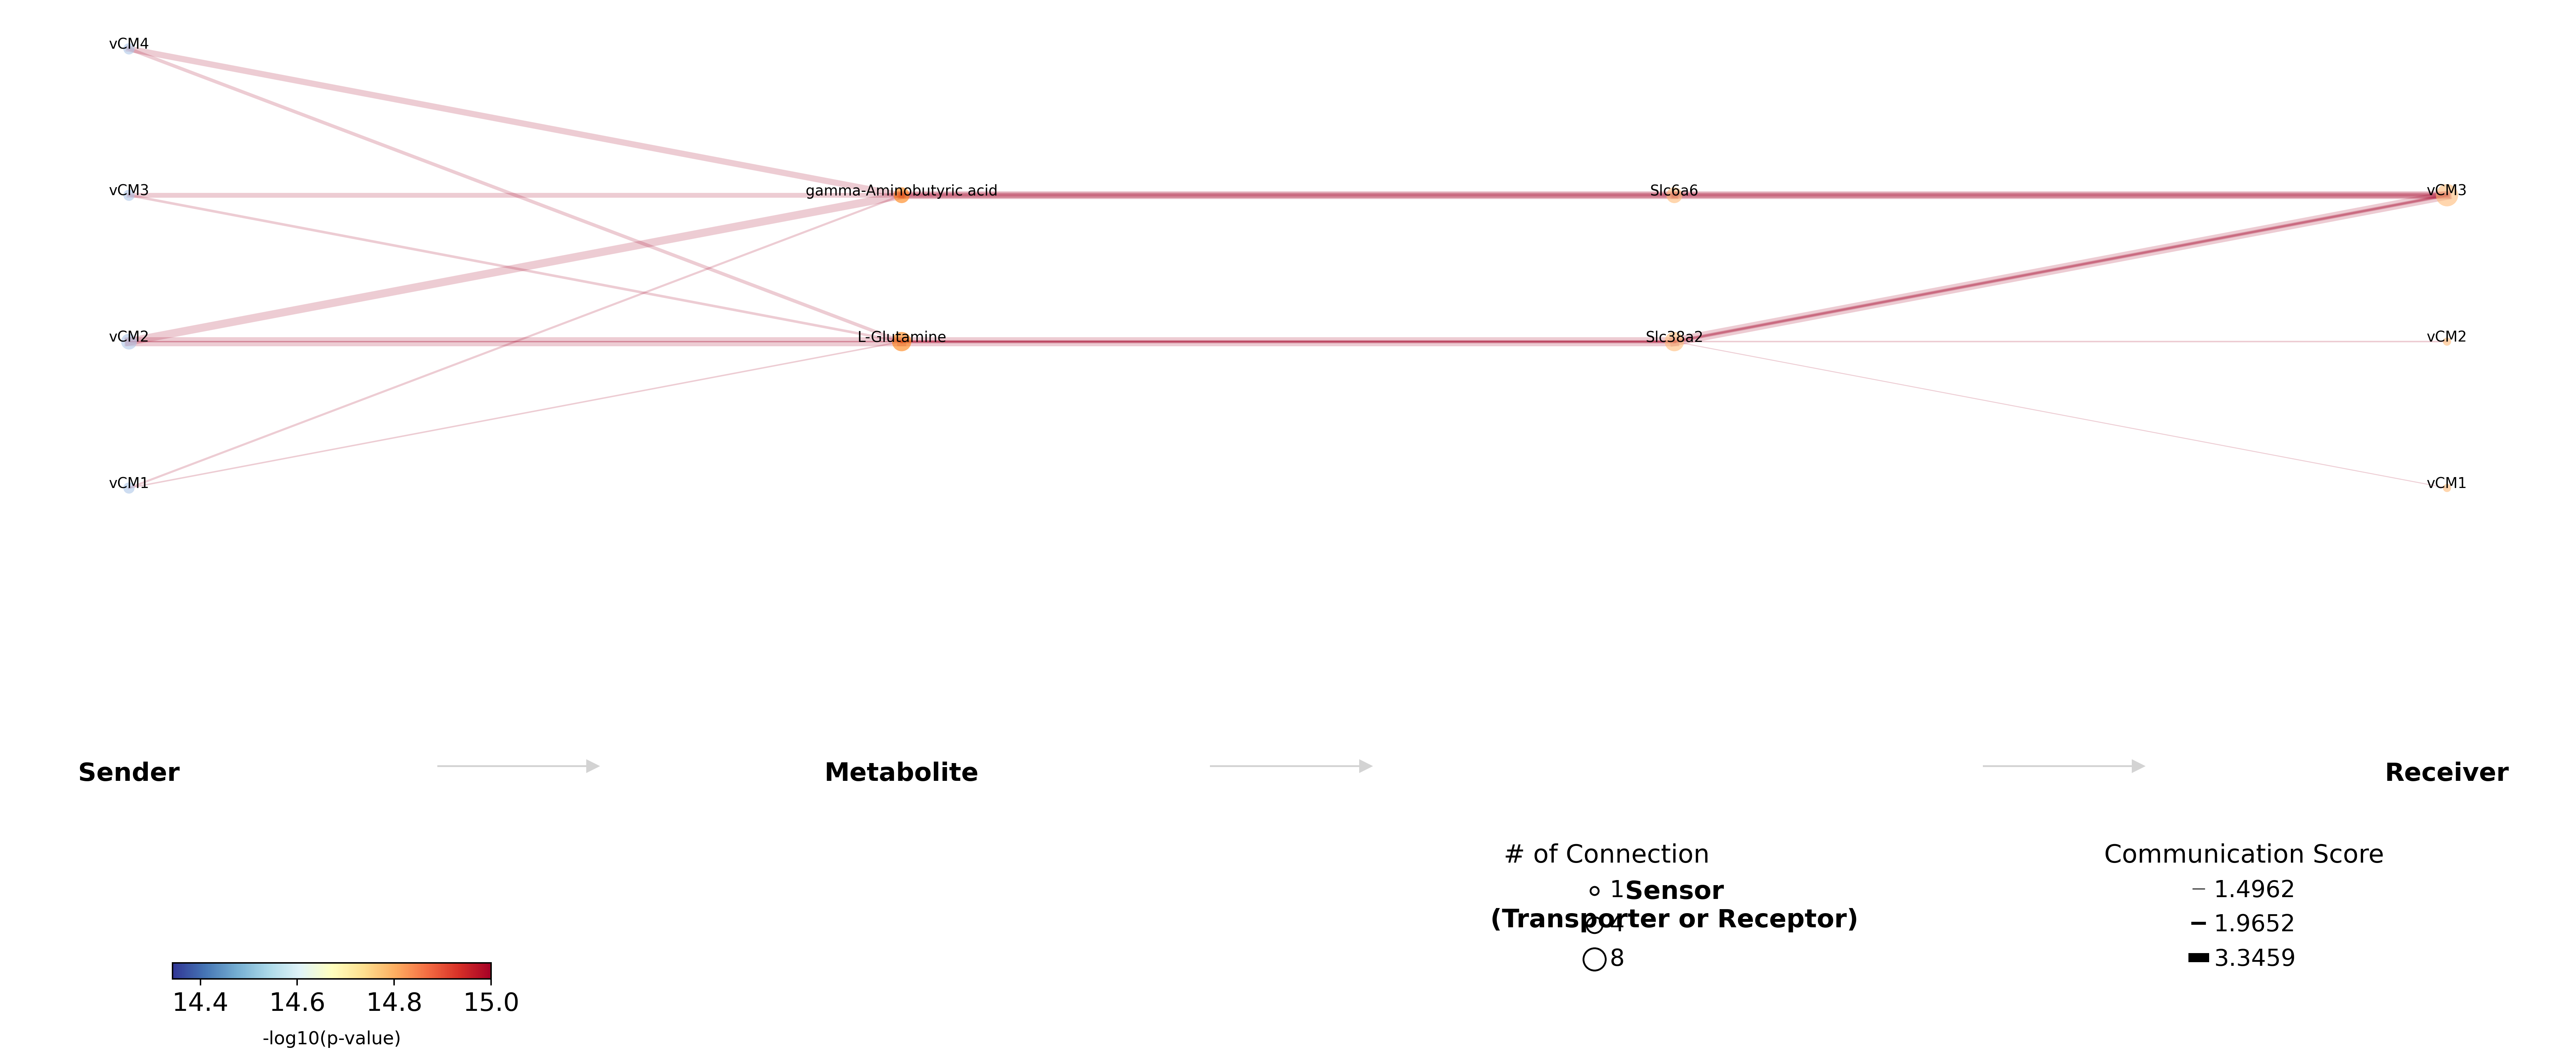

In [19]:
mebo_obj.FlowPlot(
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                sender_focus = [],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = [],
                remove_unrelevant = False,
                and_or = 'and',
                node_label_size = 8,
                node_alpha = 0.6,
                figsize = (25,10),
                node_cmap = 'tab20',
                line_cmap = 'RdYlBu_r',
                line_vmin = None,
                line_vmax = 15,
                node_size_norm = (20, 150),
                linewidth_norm = (0.5, 5),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                text_outline = False,
                return_fig = False
            )

[March 12, 2024 09:53:57]: plot flow plot to show the communications from Sender -> Metabolite -> Sensor -> Receiver


RuntimeError: Colorbar layout of new layout engine not compatible with old engine, and a colorbar has been created.  Engine not changed.

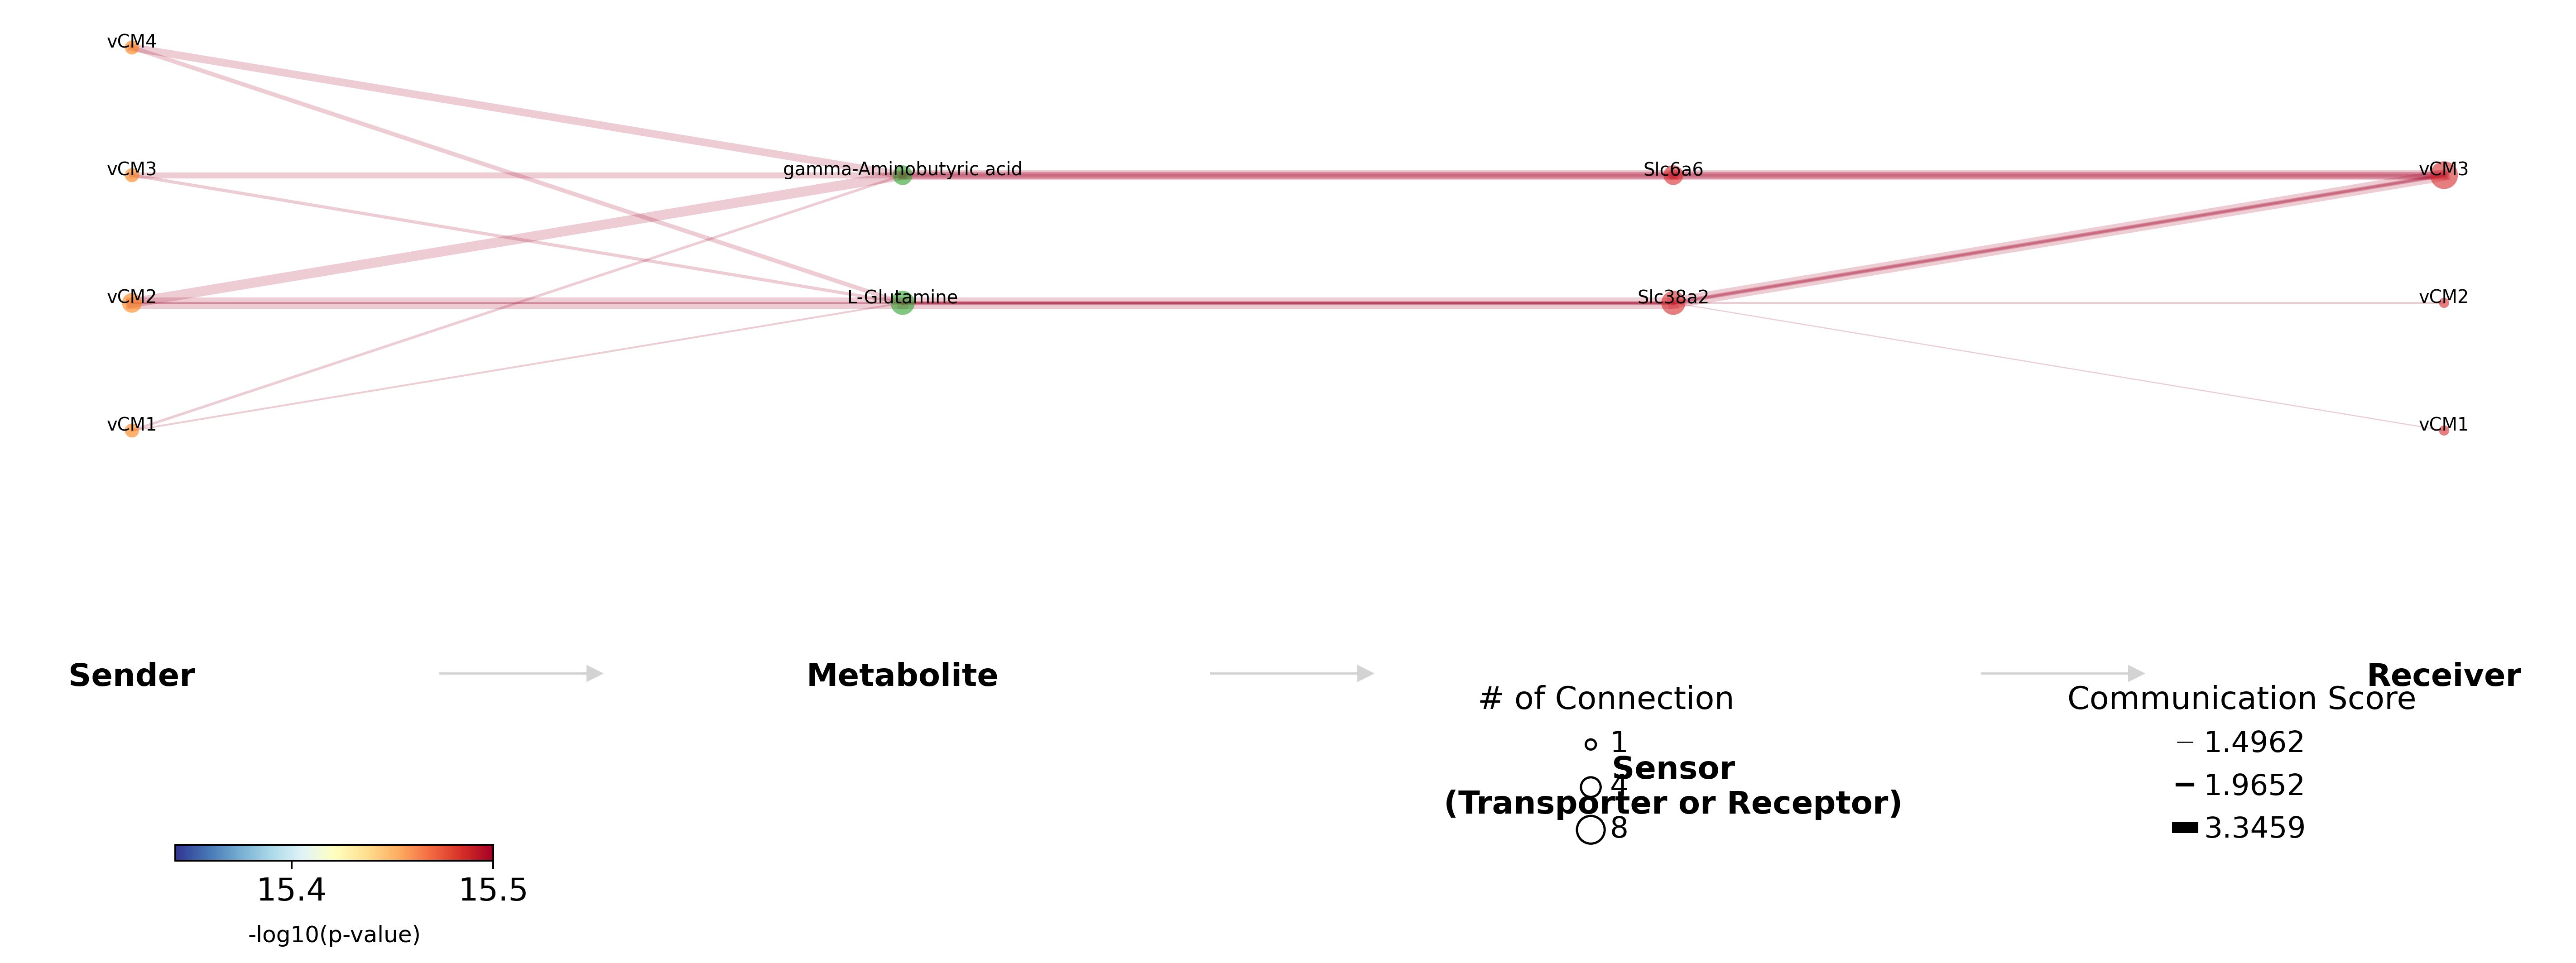

In [20]:
mebo_obj.FlowPlot(
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                sender_focus = [],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = [],
                remove_unrelevant = True,
                and_or = 'and',
                node_label_size = 8,
                node_alpha = 0.6,
                figsize = (20,7),
                node_cmap = 'tab10',
                line_cmap = 'RdYlBu_r',
                line_vmin = None,
                line_vmax = 15.5,
                node_size_norm = (20, 150),
                linewidth_norm = (0.5, 5),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                text_outline = False,
                return_fig = False
            )

- Visualization of the metabolite level or sensor expression in cell groups

[March 12, 2024 09:53:59]: Warnings: no sensors to plot
[March 12, 2024 09:53:59]: Find metabolites ['gamma-Aminobutyric acid', 'L-Glutamine'] to plot violin


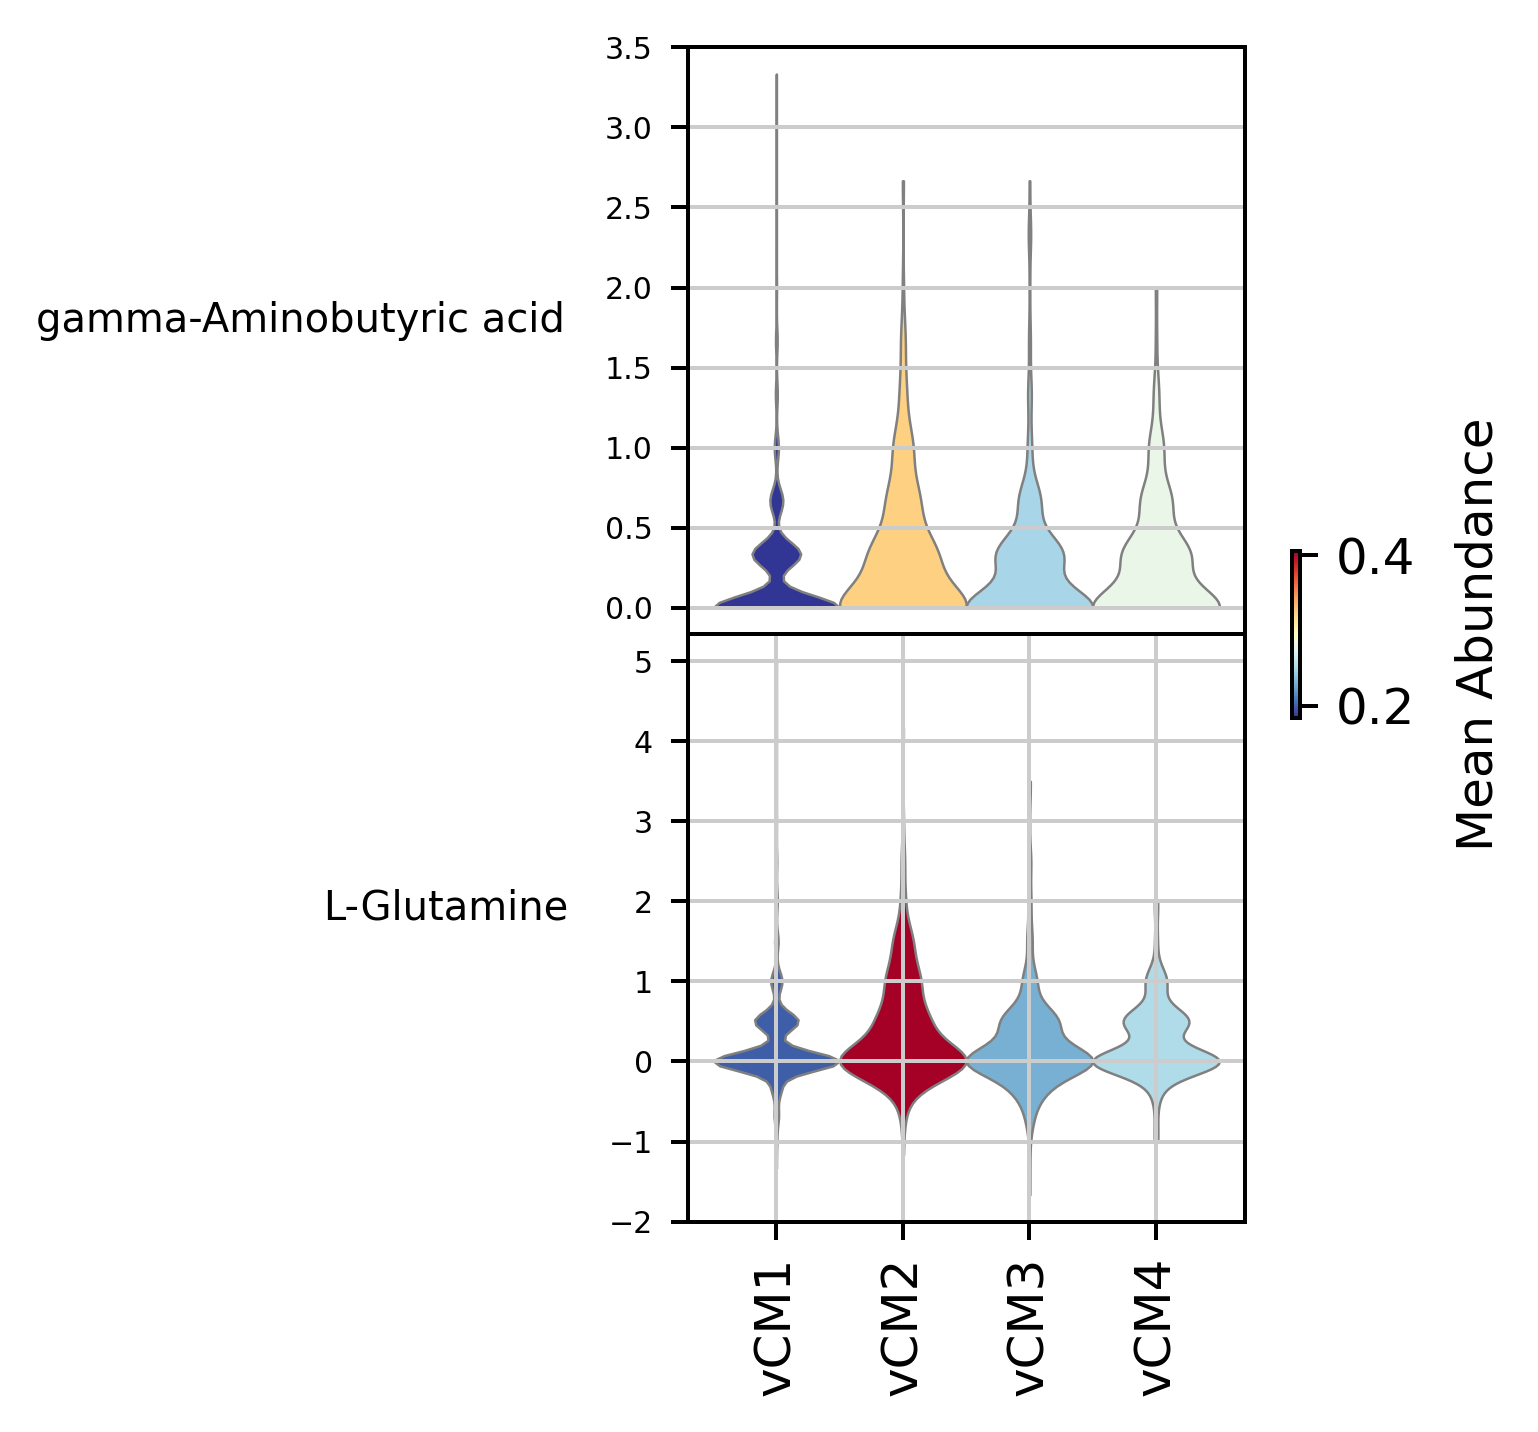

In [21]:
commu_df = mebo_obj.commu_res.copy()
good_met = commu_df[(commu_df['permutation_test_fdr']<=0.05)]['Metabolite_Name'].sort_values().unique()

mebo_obj.violin_plot(
                    sensor_or_met = good_met[:10], ## only top 5 as example
                    cell_focus = [],
                    cmap = 'RdYlBu_r',
                    vmin = None,
                    vmax = None,
                    figsize = 'auto',
                    cbar_title = '',
                    save = None,
                    show_plot = True
                    )

[March 12, 2024 09:54:01]: Find genes Index(['Slc6a6', 'Slc38a2'], dtype='object') to plot violin


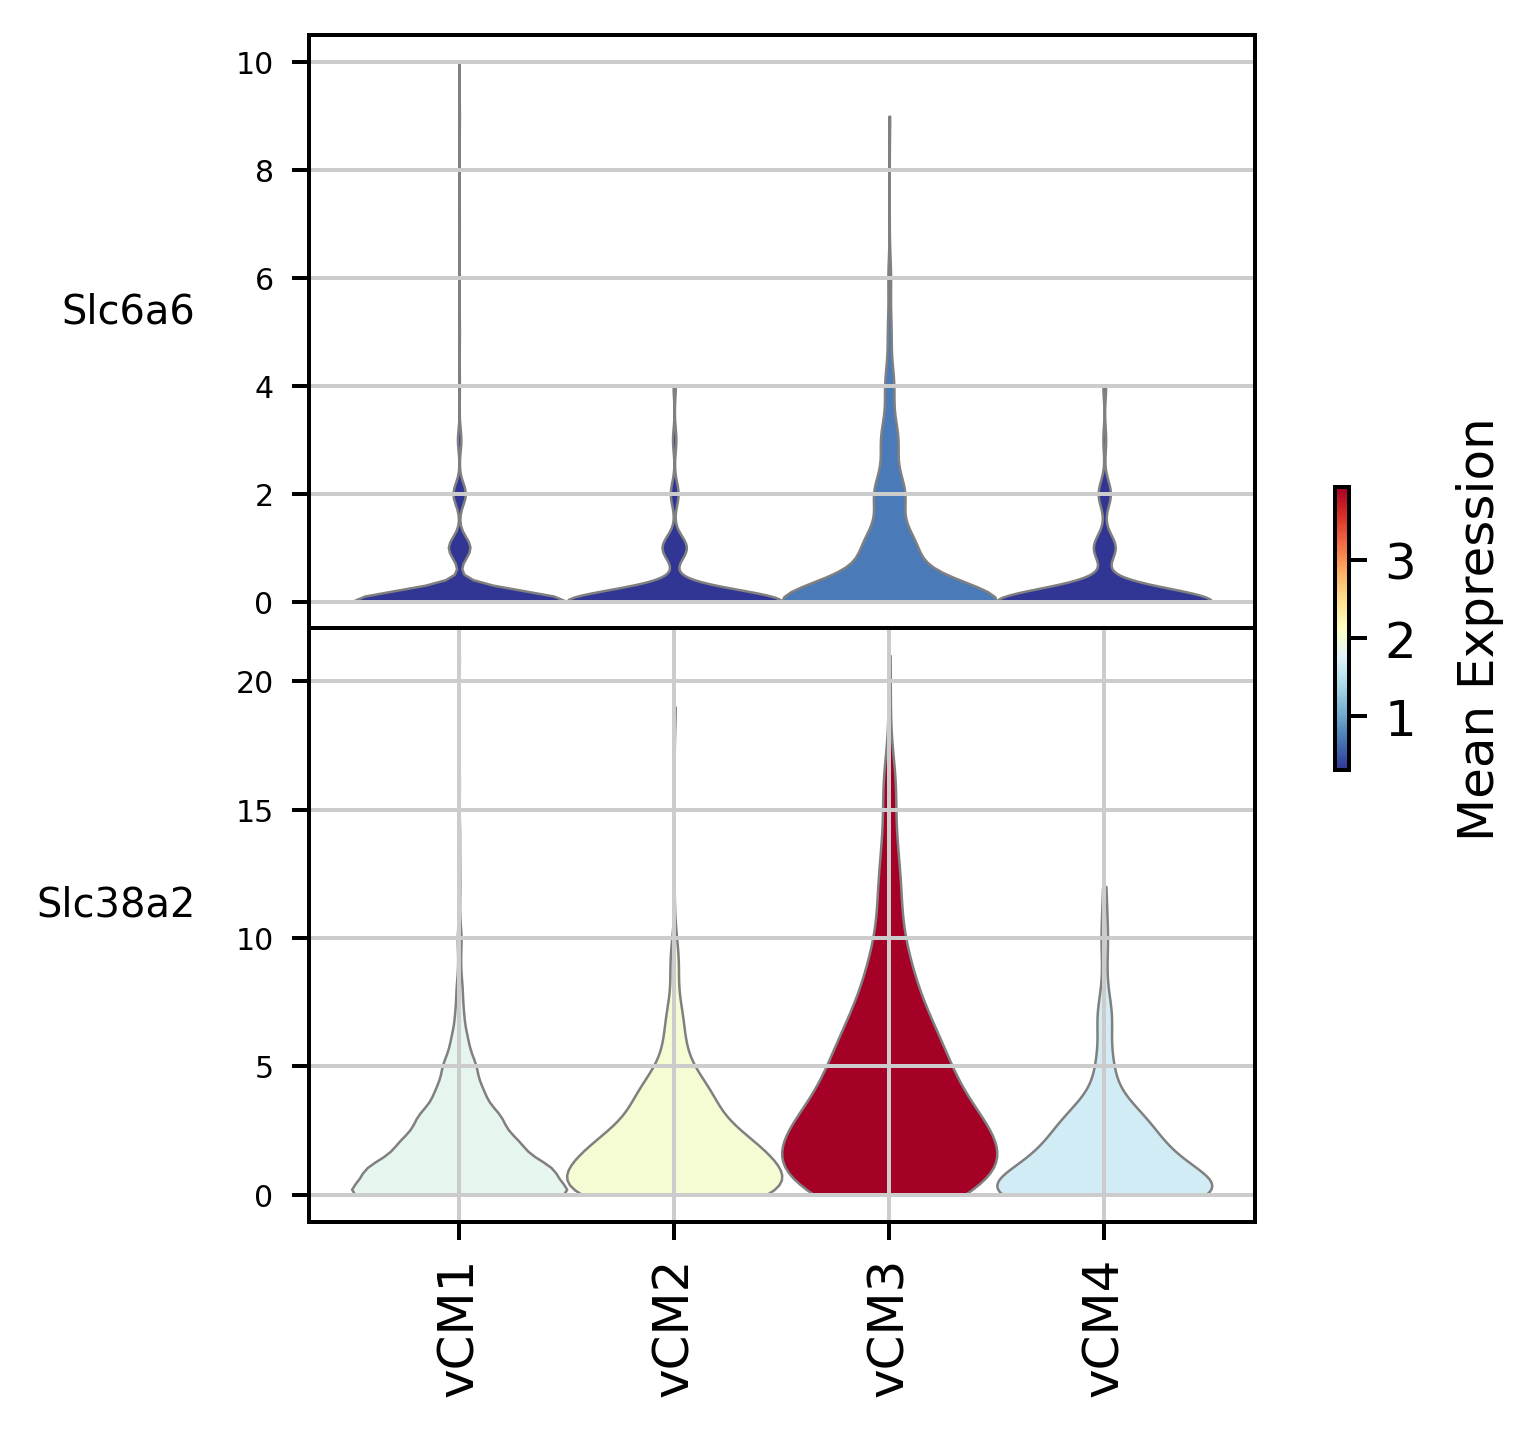

[March 12, 2024 09:54:01]: Warnings: no metabolites to plot


In [22]:
good_sensor = commu_df[(commu_df['permutation_test_fdr']<=0.05)]['Sensor'].sort_values().unique()

mebo_obj.violin_plot(
                    sensor_or_met = good_sensor[:10],## only top 5 as example
                    cell_focus = [],
                    cmap = 'RdYlBu_r',
                    vmin = None,
                    vmax = None,
                    figsize = 'auto',
                    cbar_title = '',
                    save = None,
                    show_plot = True
                    )
